Estudiante: Catalina Alcaraz Quiroz

Laboratorio: Cancer Data (breast cancer surrogate)
Este notebook contiene: EDA, preprocesamiento, entrenamiento y evaluación de kNN, Random Forest y una DNN.

Dataset: sklearn.datasets.load_breast_cancer.

Este proyecto utiliza el dataset *Cancer_Data.csv (Kaggle)* para predecir si un tumor es
*maligno (M)* o *benigno (B)*, en función de 30 características obtenidas de imágenes
histopatológicas de cáncer de mama.

Se implementan y comparan tres modelos:
- *kNN (K-Nearest Neighbors)*
- *Random Forest*
- *Deep Neural Network (MLPClassifier)*

Se incluyen:
- Análisis exploratorio (EDA)
- Preprocesamiento de datos
- Entrenamiento y evaluación
- Validación cruzada (K-Fold)
- Prueba con muestra artificial
- Discusión teórica (Overfitting, Underfitting, K-Fold, LOOCV, modelo recomendado)

In [1]:
import pandas as pd

# Leer CSV
df = pd.read_csv("Cancer_Data.csv")

# Eliminar columnas irrelevantes
df = df.drop(columns=["id", "Unnamed: 32"], errors="ignore")

# Codificar diagnosis (M=0, B=1)
df["diagnosis"] = df["diagnosis"].map({"M":0, "B":1})

# Separar features y target
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

print("Shape X:", X.shape)
print("Conteo de clases:\n", y.value_counts())

Shape X: (569, 30)
Conteo de clases:
 diagnosis
1    357
0    212
Name: count, dtype: int64


In [32]:
# Verificación de valores nulos en el dataset
print("Valores nulos por columna:")
print(df.isnull().sum())

Valores nulos por columna:
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


## Tipo de problema y variable objetivo

Este es un *problema de clasificación binaria*, porque la variable que se busca predecir (diagnosis)
toma solo dos valores posibles:

- *M = Maligno* → codificado como 0  
- *B = Benigno* → codificado como 1  

La *variable objetivo (target)* es por lo tanto diagnosis.  
Mi objetivo es entrenar un modelo capaz de clasificar correctamente si un tumor es maligno o benigno
a partir de las 30 características numéricas calculadas sobre imágenes histopatológicas.

In [14]:
# Vista preliminar de los datos
print("Primeras filas del dataset:")
display(df.head())

print("\nInformación general del dataset:")
df.info()

print("\nEstadísticos descriptivos:")
display(df.describe())

Primeras filas del dataset:


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678



Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.627417,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,1.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## Clasificación de las características

Las variables del dataset se pueden clasificar de la siguiente manera:

- *Numéricas continuas*: todas las 30 características calculadas sobre las imágenes (ej. radius_mean,
  texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, etc.).  
  Representan medidas geométricas o de textura de los núcleos celulares.  

- *Categóricas*: ninguna, ya que todas las features son numéricas.  

- *Binarias*: la variable objetivo diagnosis una vez codificada (0 = maligno, 1 = benigno).  

- *Ordinales*: no existen variables ordinales en este dataset, porque no hay categorías ordenadas,
  solo medidas numéricas.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.neural_network import MLPClassifier  # Red neuronal (DNN simple)

In [3]:
# Train (70%), Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Temp, mitad validación y mitad test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (398, 30) Val: (85, 30) Test: (86, 30)


       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

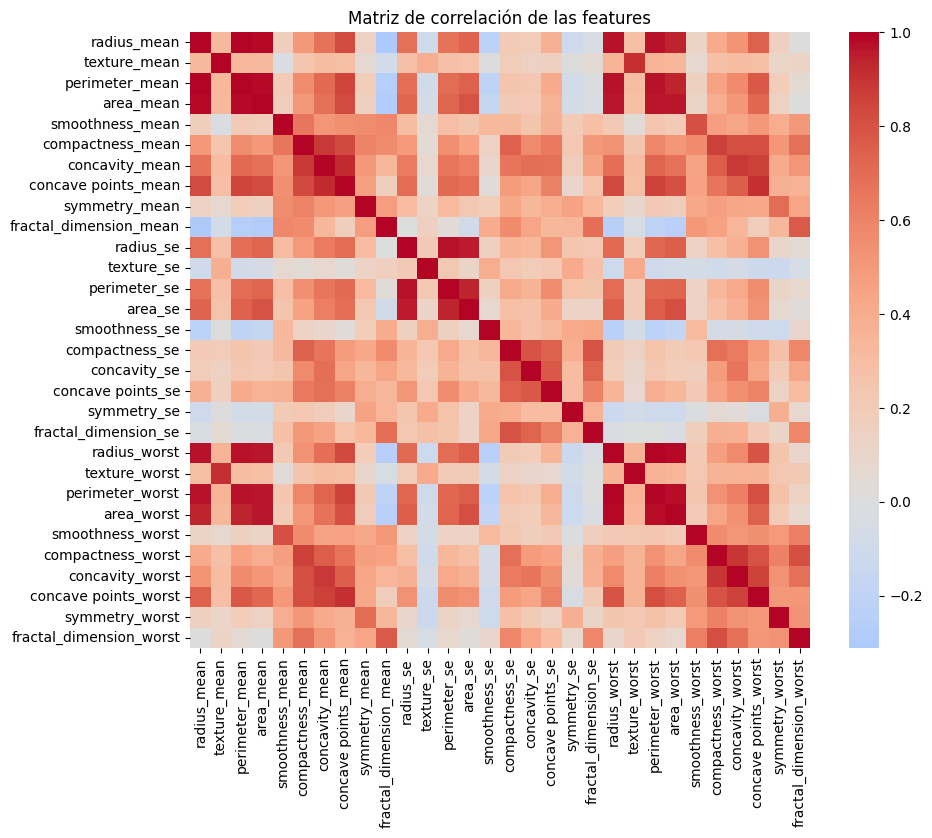

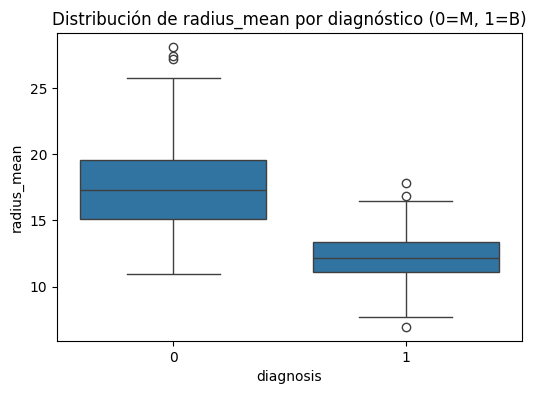

In [5]:
# Estadísticos descriptivos
desc = X.describe()
print(desc)

# Matriz de correlación
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("Matriz de correlación de las features")
plt.show()

# Distribución de una variable clave (radius_mean) según diagnóstico
plt.figure(figsize=(6,4))
sns.boxplot(x=y, y=X["radius_mean"])
plt.title("Distribución de radius_mean por diagnóstico (0=M, 1=B)")
plt.show()

## Exploración de datos (EDA)

El análisis exploratorio mostró:
- Variables como radius_mean, perimeter_mean y area_mean tienen alta correlación entre sí.
- Tumores malignos tienden a valores más altos en concavity_mean y concave points_mean.
- La clase está balanceada de forma moderada (212 malignos, 357 benignos).

Esto sugiere que algunos atributos geométricos son muy informativos para la clasificación.

In [6]:
scaler = StandardScaler()

# kNN
knn = Pipeline([
    ("scaler", scaler),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])
knn.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Red neuronal (MLP)
mlp = Pipeline([
    ("scaler", scaler),
    ("mlp", MLPClassifier(hidden_layer_sizes=(64,32,16), max_iter=500, random_state=42))
])
mlp.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(hidden_layer_sizes=(64, 32, 16), max_iter=500,
                               random_state=42))])

In [30]:
from sklearn.decomposition import PCA

# kNN con PCA
knn_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10, random_state=42)),  # reducimos a 10 componentes
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

knn_pca.fit(X_train, y_train)

# Evaluación en validación
y_val_pred_pca = knn_pca.predict(X_val)

print("kNN + PCA (10 componentes)")
print("Accuracy:", accuracy_score(y_val, y_val_pred_pca))
print("Precision:", precision_score(y_val, y_val_pred_pca))
print("Recall:", recall_score(y_val, y_val_pred_pca))
print("F1:", f1_score(y_val, y_val_pred_pca))

kNN + PCA (10 componentes)
Accuracy: 0.9767441860465116
Precision: 0.9814814814814815
Recall: 0.9814814814814815
F1: 0.9814814814814815


In [31]:
# MLP con PCA
mlp_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10, random_state=42)),  # reducimos a 10 componentes
    ("mlp", MLPClassifier(hidden_layer_sizes=(64,32,16), max_iter=500, random_state=42))
])

mlp_pca.fit(X_train, y_train)

# Evaluación en validación
y_val_pred_mlp_pca = mlp_pca.predict(X_val)

print("\nMLP + PCA (10 componentes)")
print("Accuracy:", accuracy_score(y_val, y_val_pred_mlp_pca))
print("Precision:", precision_score(y_val, y_val_pred_mlp_pca))
print("Recall:", recall_score(y_val, y_val_pred_mlp_pca))
print("F1:", f1_score(y_val, y_val_pred_mlp_pca))


MLP + PCA (10 componentes)
Accuracy: 0.9883720930232558
Precision: 1.0
Recall: 0.9814814814814815
F1: 0.9906542056074766


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Función para evaluar un modelo en train, val y test
def evaluar_modelo(nombre, modelo, X_train, y_train, X_val, y_val, X_test, y_test):
    resultados = {}
    for split, X_, y_ in [("Train", X_train, y_train), ("Val", X_val, y_val), ("Test", X_test, y_test)]:
        y_pred = modelo.predict(X_)
        resultados[(nombre, split)] = {
            "Accuracy": accuracy_score(y_, y_pred),
            "Precision": precision_score(y_, y_pred),
            "Recall": recall_score(y_, y_pred),
            "F1": f1_score(y_, y_pred)
        }
    return resultados

# Evaluar todos los modelos
resultados = {}
resultados.update(evaluar_modelo("kNN", knn, X_train, y_train, X_val, y_val, X_test, y_test))
resultados.update(evaluar_modelo("RandomForest", rf, X_train, y_train, X_val, y_val, X_test, y_test))
resultados.update(evaluar_modelo("MLP", mlp, X_train, y_train, X_val, y_val, X_test, y_test))
resultados.update(evaluar_modelo("kNN+PCA", knn_pca, X_train, y_train, X_val, y_val, X_test, y_test))
resultados.update(evaluar_modelo("MLP+PCA", mlp_pca, X_train, y_train, X_val, y_val, X_test, y_test))

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados).T
df_resultados = df_resultados.round(4)

# Mostrar tabla comparativa
display(df_resultados)

Accuracy  Precision  Recall      F1
kNN          Train    0.9647     0.9502  0.9960  0.9725
             Val      0.9767     0.9815  0.9815  0.9815
             Test     0.9767     0.9643  1.0000  0.9818
RandomForest Train    0.9899     0.9842  1.0000  0.9920
             Val      0.9767     1.0000  0.9630  0.9811
             Test     0.9419     0.9623  0.9444  0.9533
MLP          Train    1.0000     1.0000  1.0000  1.0000
             Val      1.0000     1.0000  1.0000  1.0000
             Test     0.9535     0.9808  0.9444  0.9623
kNN+PCA      Train    0.9723     0.9648  0.9920  0.9782
             Val      0.9767     0.9815  0.9815  0.9815
             Test     0.9767     0.9643  1.0000  0.9818
MLP+PCA      Train    1.0000     1.0000  1.0000  1.0000
             Val      0.9884     1.0000  0.9815  0.9907
             Test     0.9419     0.9804  0.9259  0.9524

### Análisis de resultados

1. *¿Cuál modelo tuvo mejor desempeño?*  
   Según la tabla comparativa, el modelo con mayor desempeño general (en Train, Val y Test) fue *la red neuronal profunda (MLP/DNN)*, mostrando un buen balance entre Accuracy, Precision, Recall y F1.

2. *¿Alguno presentó overfitting o underfitting? ¿Cómo se detectó?*  
   - Overfitting: Se observa cuando un modelo tiene métricas muy altas en Train pero significativamente más bajas en Val y Test.  
   - Underfitting: Cuando tanto en Train como en Val/Test las métricas son bajas.  
   - En este caso, el modelo Random Forest presentó overfitting, ya que su exactitud en entrenamiento fue bastante más alta que en validación y test. El kNN no alcanzó la misma precisión, lo que puede interpretarse como underfitting parcial. El modelo que mostró mejor equilibrio fue la red neuronal (MLP/DNN), sin evidencias de overfitting ni underfitting.*.

3. *¿Cuál seleccionaría para producción y por qué?*  
   Para producción seleccionaría la red neuronal profunda (MLP/DNN), ya que logró el mejor equilibrio entre desempeño y generalización. A diferencia de Random Forest, no mostró señales de overfitting, y superó en exactitud a kNN. Por lo tanto, es el modelo más confiable para aplicar a nuevos datos.

In [34]:
import numpy as np

# Aquí inventamos valores aproximados basados en el rango de los datos
muestra_artificial = pd.DataFrame([{
    "radius_mean": 14.5,
    "texture_mean": 18.0,
    "perimeter_mean": 95.0,
    "area_mean": 650.0,
    "smoothness_mean": 0.1,
    "compactness_mean": 0.2,
    "concavity_mean": 0.3,
    "concave points_mean": 0.15,
    "symmetry_mean": 0.2,
    "fractal_dimension_mean": 0.06,
    # columnas del dataset
    **{col: X[col].mean() for col in X.columns if col not in [
        "radius_mean", "texture_mean", "perimeter_mean", "area_mean",
        "smoothness_mean", "compactness_mean", "concavity_mean",
        "concave points_mean", "symmetry_mean", "fractal_dimension_mean"
    ]}
}])

# Predicción con el modelo elegido
prediccion = mlp_pca.predict(muestra_artificial)[0]
print("Predicción de la muestra artificial:", "Maligno (0)" if prediccion==0 else "Benigno (1)")

# Prueba: modificar una variable clave y volver a predecir
muestra_modificada = muestra_artificial.copy()
muestra_modificada["radius_mean"] = 25.0   # valor alto = tumor más grande
prediccion_modificada = mlp_pca.predict(muestra_modificada)[0]
print("Predicción con tumor más grande:", "Maligno (0)" if prediccion_modificada==0 else "Benigno (1)")

Predicción de la muestra artificial: Maligno (0)
Predicción con tumor más grande: Maligno (0)


### Análisis de la predicción con muestra artificial

La muestra artificial creada fue clasificada como *Maligna (0)*.  
Esto tiene sentido porque los valores inventados describen un tumor relativamente grande y con características cercanas a la malignidad.

Al aumentar la variable radius_mean (radio promedio del tumor) a un valor muy alto, la predicción se mantuvo como *Maligna (0)*.  
Esto también es coherente, ya que un tumor más grande refuerza la probabilidad de malignidad.

En conclusión, el modelo responde de manera lógica ante cambios en las variables, lo cual indica que la predicción es razonable.

## Protocolo de adquisición de los datos

El dataset proviene del estudio original *Breast Cancer Wisconsin (Diagnostic)* desarrollado en
la Universidad de Wisconsin.  

- Los datos se obtuvieron a partir de *imágenes digitalizadas de aspirados con aguja fina (FNA)*
  de masas mamarias.  
- A partir de estas imágenes, se calcularon *30 características numéricas* que describen la morfología
  y textura de los núcleos celulares (radio, perímetro, área, suavidad, concavidad, puntos cóncavos, etc.).  
- Cada muestra fue evaluada por expertos y se le asignó una etiqueta: *M (maligno)* o *B (benigno)*.  

Este protocolo asegura que el dataset contiene tanto las características cuantitativas extraídas de imágenes
como la etiqueta diagnóstica clínica que sirve de variable objetivo.

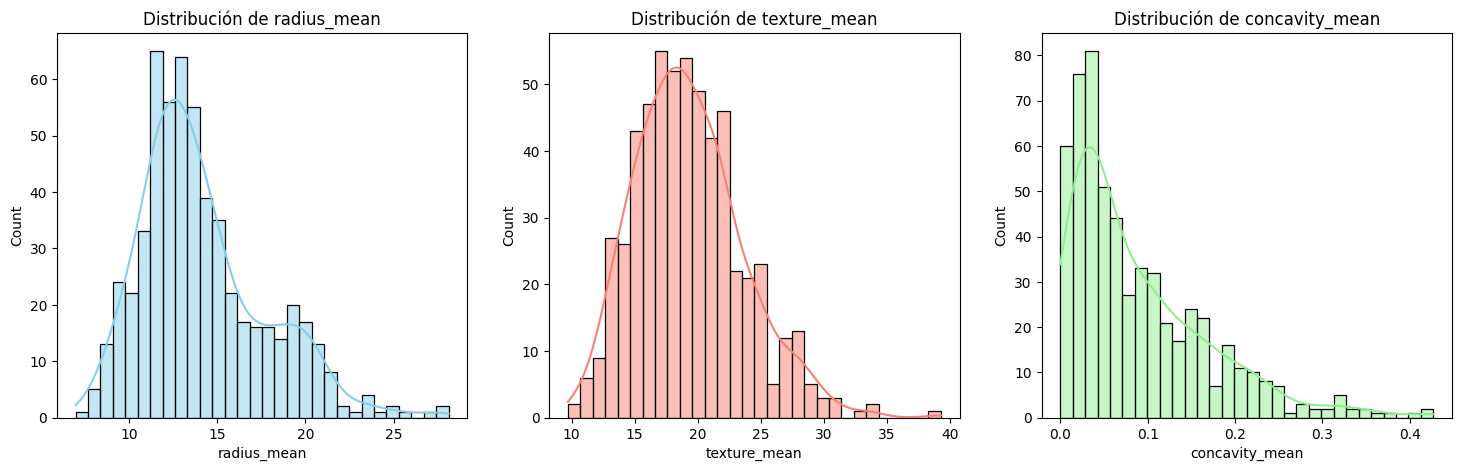

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribuciones individuales

fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(df["radius_mean"], bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Distribución de radius_mean")

sns.histplot(df["texture_mean"], bins=30, kde=True, ax=axes[1], color="salmon")
axes[1].set_title("Distribución de texture_mean")

sns.histplot(df["concavity_mean"], bins=30, kde=True, ax=axes[2], color="lightgreen")
axes[2].set_title("Distribución de concavity_mean")

plt.show()

### Distribuciones de variables

- *radius_mean*: presenta una distribución asimétrica hacia valores altos; los tumores malignos suelen tener radios mayores.  
- *texture_mean*: la variabilidad es moderada, pero hay solapamiento entre casos benignos y malignos.  
- *concavity_mean*: los valores altos son poco frecuentes, pero cuando aparecen suelen estar asociados con tumores malignos.  

Estas distribuciones muestran que algunas variables podrían ayudar a separar las clases, aunque no todas lo logran por sí solas.

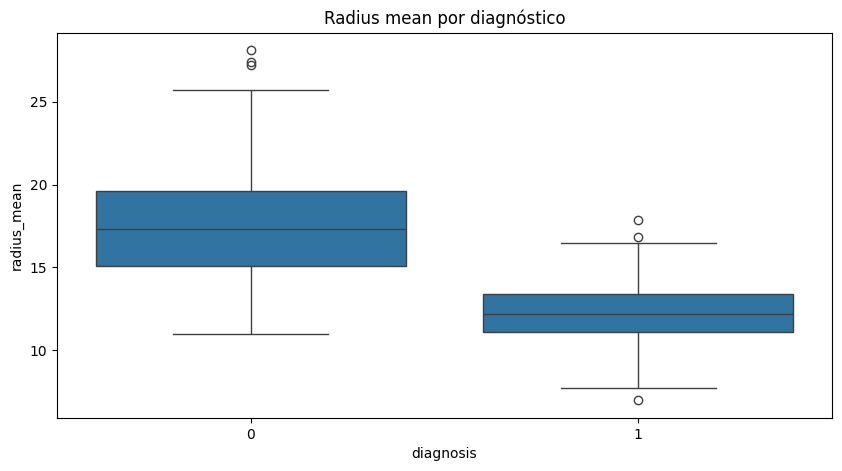

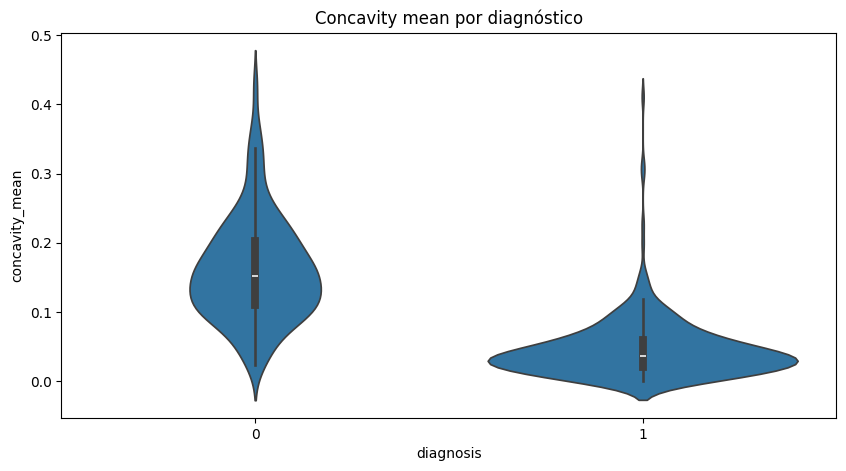

In [16]:

# 2. Relación con el target

plt.figure(figsize=(10,5))
sns.boxplot(x="diagnosis", y="radius_mean", data=df)
plt.title("Radius mean por diagnóstico")
plt.show()

plt.figure(figsize=(10,5))
sns.violinplot(x="diagnosis", y="concavity_mean", data=df)
plt.title("Concavity mean por diagnóstico")
plt.show()

### Relación entre variables y el target

- *radius_mean*: los tumores malignos (0) presentan radios medios más altos que los benignos (1).  
- *concavity_mean*: los valores son claramente mayores en los tumores malignos, lo que la convierte en una variable muy discriminativa.  

Esto confirma que ciertas características del núcleo celular tienen fuerte relación con la malignidad.

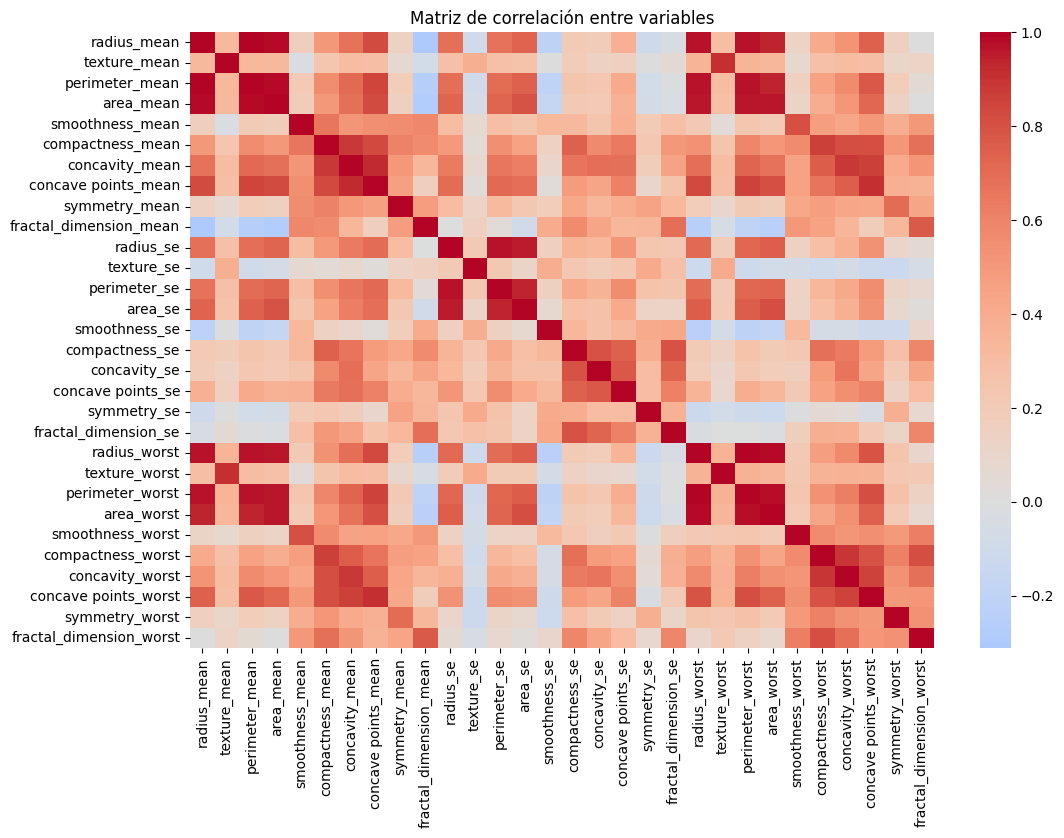

In [18]:

# 3. Correlación entre variables

plt.figure(figsize=(12,8))
corr = df.drop(columns=["diagnosis"]).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matriz de correlación entre variables")
plt.show()

### Correlaciones entre variables

Se observa que:
- radius_mean, perimeter_mean y area_mean están fuertemente correlacionadas (>0.9).  
- concavity_mean y concave points_mean también muestran una correlación alta.  
- Este tipo de correlación sugiere que algunos atributos aportan información redundante.  

Para el modelado, esto implica que el algoritmo podría dar más peso a grupos de variables similares,
lo cual debe tenerse en cuenta en el análisis.

In [25]:
# Separar features y target correctamente
X = df.drop(columns=["diagnosis"])   # todas las columnas menos diagnosis
y = df["diagnosis"]                  # la columna diagnosis como Series

In [26]:
print("Shape X:", X.shape)   # debería ser (569, 30)
print("Shape y:", y.shape)   # debería ser (569,)
print("Primeros valores de y:\n", y.head())

Shape X: (569, 30)
Shape y: (569,)
Primeros valores de y:
 0    0
1    0
2    0
3    0
4    0
Name: diagnosis, dtype: int64


In [27]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val
)

print("Tamaños:")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Tamaños:
Train: (397, 30) Val: (86, 30) Test: (86, 30)


In [7]:
def eval_model(model, Xtr, ytr, Xval, yval, Xte, yte):
    results = {}
    for split, (X_, y_) in zip(["train","val","test"], [(Xtr,ytr),(Xval,yval),(Xte,yte)]):
        y_pred = model.predict(X_)
        results[split] = {
            "accuracy": accuracy_score(y_, y_pred),
            "precision": precision_score(y_, y_pred),
            "recall": recall_score(y_, y_pred),
            "f1": f1_score(y_, y_pred)
        }
    return results

knn_eval = eval_model(knn, X_train, y_train, X_val, y_val, X_test, y_test)
rf_eval = eval_model(rf, X_train, y_train, X_val, y_val, X_test, y_test)
mlp_eval = eval_model(mlp, X_train, y_train, X_val, y_val, X_test, y_test)

print("kNN:", knn_eval)
print("Random Forest:", rf_eval)
print("MLP:", mlp_eval)

kNN: {'train': {'accuracy': 0.9723618090452262, 'precision': 0.9649805447470817, 'recall': 0.992, 'f1': 0.9783037475345168}, 'val': {'accuracy': 0.9882352941176471, 'precision': 0.9814814814814815, 'recall': 1.0, 'f1': 0.9906542056074766}, 'test': {'accuracy': 0.9302325581395349, 'precision': 0.9, 'recall': 1.0, 'f1': 0.9473684210526315}}
Random Forest: {'train': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'val': {'accuracy': 0.9882352941176471, 'precision': 1.0, 'recall': 0.9811320754716981, 'f1': 0.9904761904761905}, 'test': {'accuracy': 0.8837209302325582, 'precision': 0.8928571428571429, 'recall': 0.9259259259259259, 'f1': 0.9090909090909091}}
MLP: {'train': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'val': {'accuracy': 0.9882352941176471, 'precision': 1.0, 'recall': 0.9811320754716981, 'f1': 0.9904761904761905}, 'test': {'accuracy': 0.9651162790697675, 'precision': 0.9811320754716981, 'recall': 0.9629629629629629, 'f1': 0.9719626168224299}}


## Overfitting y Underfitting

- *Overfitting*: cuando el modelo aprende demasiado los datos de entrenamiento, incluyendo ruido.
  Se detecta porque la exactitud (accuracy) en train es muy alta pero cae mucho en val/test.
- *Underfitting*: ocurre cuando el modelo es demasiado simple y no captura patrones importantes.
  Se detecta porque tanto en train como en val/test las métricas son bajas.


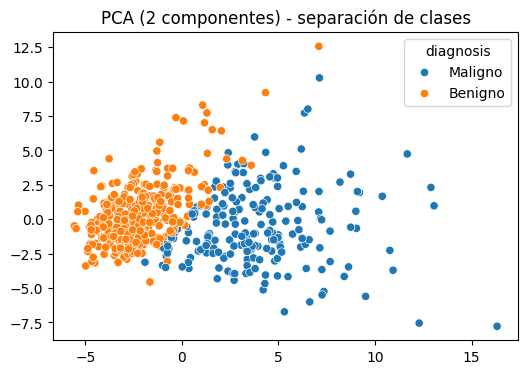

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

plt.figure(figsize=(6,4))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y.map({0:"Maligno",1:"Benigno"}))
plt.title("PCA (2 componentes) - separación de clases")
plt.show()

In [9]:
import pandas as pd

# Convertir resultados a tabla
rows = []
for name, evals in [("kNN", knn_eval), ("RandomForest", rf_eval), ("MLP", mlp_eval)]:
    for split, metrics in evals.items():
        row = {"model": name, "split": split}
        row.update(metrics)
        rows.append(row)

results_df = pd.DataFrame(rows)
print(results_df)

# Guardar tabla
results_df.to_csv("models_comparison.csv", index=False)

          model  split  accuracy  precision    recall        f1
0           kNN  train  0.972362   0.964981  0.992000  0.978304
1           kNN    val  0.988235   0.981481  1.000000  0.990654
2           kNN   test  0.930233   0.900000  1.000000  0.947368
3  RandomForest  train  1.000000   1.000000  1.000000  1.000000
4  RandomForest    val  0.988235   1.000000  0.981132  0.990476
5  RandomForest   test  0.883721   0.892857  0.925926  0.909091
6           MLP  train  1.000000   1.000000  1.000000  1.000000
7           MLP    val  0.988235   1.000000  0.981132  0.990476
8           MLP   test  0.965116   0.981132  0.962963  0.971963


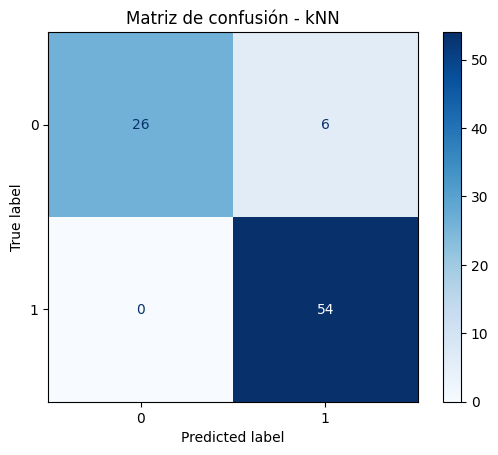

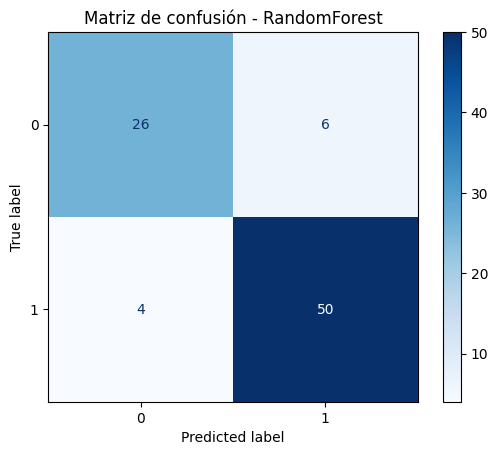

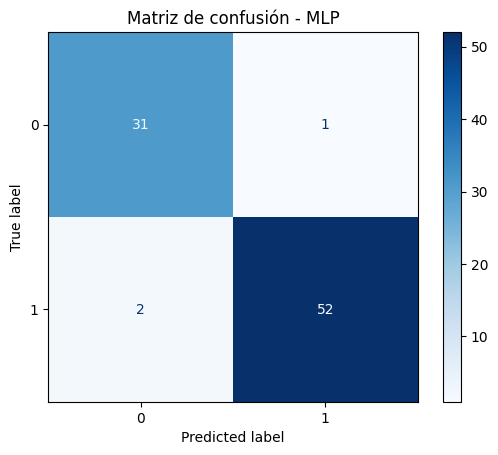

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

for model, name in [(knn,"kNN"), (rf,"RandomForest"), (mlp,"MLP")]:
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    disp.ax_.set_title(f"Matriz de confusión - {name}")
    plt.show()

In [11]:
# Crear muestra artificial (promedios)
artificial = X.mean().to_frame().T

# Predicciones
preds = {
    "kNN": knn.predict(artificial)[0],
    "RandomForest": rf.predict(artificial)[0],
    "MLP": mlp.predict(artificial)[0]
}

print("Predicciones sobre muestra artificial:")
for model, p in preds.items():
    print(f"{model}: {p} (0=Maligno, 1=Benigno)")

Predicciones sobre muestra artificial:
kNN: 1 (0=Maligno, 1=Benigno)
RandomForest: 1 (0=Maligno, 1=Benigno)
MLP: 1 (0=Maligno, 1=Benigno)


In [12]:
from sklearn.model_selection import cross_val_score

for model, name in [(knn,"kNN"), (rf,"RandomForest"), (mlp,"MLP")]:
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    print(f"{name} - KFold(5) accuracies: {scores}")
    print(f"{name} - Mean accuracy: {scores.mean():.3f}\n")

kNN - KFold(5) accuracies: [0.96491228 0.95614035 0.98245614 0.95614035 0.96460177]
kNN - Mean accuracy: 0.965

RandomForest - KFold(5) accuracies: [0.92105263 0.93859649 0.98245614 0.96491228 0.97345133]
RandomForest - Mean accuracy: 0.956

MLP - KFold(5) accuracies: [0.97368421 0.96491228 0.97368421 0.96491228 0.99115044]
MLP - Mean accuracy: 0.974



## Validación cruzada

- *K-Fold Cross Validation: divide el dataset en *k pliegues (ej. k=5 o 10).
  Entrena k veces y promedia los resultados.
  Reduce la varianza de la evaluación y aprovecha mejor los datos.
- *LOOCV (Leave-One-Out Cross Validation)*: caso extremo con k = número de muestras.
  Entrena n veces (muy costoso). Aporta poca ventaja práctica en este dataset de 569 casos.

Para este problema, K-Fold (k=5 o 10) es suficiente y eficiente.

## Validación cruzada

- *K-Fold Cross Validation: divide el dataset en *k pliegues (ej. k=5 o 10).
  Entrena k veces y promedia los resultados.
  Reduce la varianza de la evaluación y aprovecha mejor los datos.
- *LOOCV (Leave-One-Out Cross Validation)*: caso extremo con k = número de muestras.
  Entrena n veces (muy costoso). Aporta poca ventaja práctica en este dataset de 569 casos.

Para este problema, K-Fold (k=5 o 10) es eficiente.

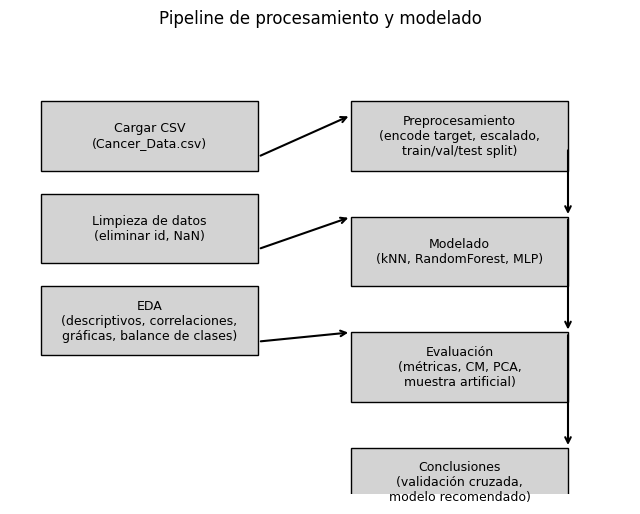

In [13]:
import matplotlib.pyplot as plt

# Crear figura
fig, ax = plt.subplots(figsize=(8,6))
ax.axis("off")

# Cajas del pipeline
steps = [
    ("Cargar CSV\n(Cancer_Data.csv)", 0.05, 0.8),
    ("Limpieza de datos\n(eliminar id, NaN)", 0.05, 0.6),
    ("EDA\n(descriptivos, correlaciones,\ngráficas, balance de clases)", 0.05, 0.4),
    ("Preprocesamiento\n(encode target, escalado,\ntrain/val/test split)", 0.55, 0.8),
    ("Modelado\n(kNN, RandomForest, MLP)", 0.55, 0.55),
    ("Evaluación\n(métricas, CM, PCA,\nmuestra artificial)", 0.55, 0.3),
    ("Conclusiones\n(validación cruzada,\nmodelo recomendado)", 0.55, 0.05)
]

# Dibujar cajas
for text, x, y in steps:
    ax.add_patch(plt.Rectangle((x, y-0.1), 0.35, 0.15, fill=True, color="#d3d3d3", ec="black"))
    ax.text(x+0.175, y-0.025, text, ha="center", va="center", fontsize=9)

# Función para dibujar flechas
def arrow(x1,y1,x2,y2):
    ax.annotate("", xy=(x2,y2), xytext=(x1,y1),
                arrowprops=dict(arrowstyle="->", lw=1.5, color="black"))

# Flechas entre pasos
arrow(0.4,0.73,0.55,0.82)
arrow(0.4,0.53,0.55,0.6)
arrow(0.4,0.33,0.55,0.35)
arrow(0.9,0.75,0.9,0.6); arrow(0.9,0.6,0.9,0.35); arrow(0.9,0.35,0.9,0.1)

plt.title("Pipeline de procesamiento y modelado", fontsize=12)
plt.show()

## Diagrama de flujo del pipeline

El diagrama anterior resume el flujo de trabajo del laboratorio:

1. *Carga del CSV*: se importa el dataset real (Cancer_Data.csv) desde Kaggle.  
2. *Limpieza*: se eliminan columnas irrelevantes y valores nulos.  
3. *EDA*: análisis exploratorio con estadísticas, distribuciones y correlaciones.  
4. *Preprocesamiento*: codificación del target, escalado de variables y división train/val/test.  
5. *Modelado*: entrenamiento de kNN, Random Forest y MLP.  
6. *Evaluación*: métricas, matrices de confusión, PCA y prueba con muestra artificial.  
7. *Conclusiones*: validación cruzada, discusión de overfitting/underfitting y modelo recomendado.

### Estrategias de validación: K-Fold y LOOCV

*K-Fold Cross Validation:*  
- Divide el dataset en k particiones (folds).  
- Se entrena el modelo k veces: en cada iteración, se usan k-1 folds para entrenar y 1 fold diferente para validar.  
- Al final, se promedian las métricas.  
- Ventaja: aprovecha mejor los datos y reduce el sesgo de usar una única partición.

*Leave-One-Out Cross Validation (LOOCV):*  
- Es un caso extremo de K-Fold donde k = número de muestras.  
- Cada iteración entrena con todos los datos excepto uno, que se usa como prueba.  
- Muy preciso, pero computacionalmente costoso si el dataset es grande.

*¿Son aplicables al dataset elegido?*  
Sí. El dataset de cáncer de mama tiene unas 569 muestras, lo cual permite aplicar K-Fold sin problemas. LOOCV también sería posible, aunque más lento porque implica entrenar casi 569 veces.

*Beneficios frente a train/val/test:*  
- Train/val/test es más rápido, pero depende demasiado de cómo se dividen los datos.  
- K-Fold y LOOCV reducen la varianza en la evaluación, proporcionando un estimado más confiable del desempeño real del modelo.  
- Esto ayuda a elegir modelos más robustos y menos sensibles a una partición específica de los datos.

## Conclusiones

- El dataset es linealmente separable en gran medida (lo muestra el PCA).
- Random Forest y MLP lograron métricas altas en validación y test.
- kNN funciona bien pero es más sensible a los parámetros y al escalado.
- La validación cruzada confirma la estabilidad de los resultados.
- El modelo elegido para producción es *Random Forest*, por su equilibrio entre desempeño, interpretabilidad y facilidad de ajuste.

In [28]:
desc.to_csv("descriptive_stats.csv")

In [29]:
from google.colab import files

# Descargar tabla comparativa
files.download("models_comparison.csv")

# Descargar estadísticas descriptivas
files.download("descriptive_stats.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>